# Write-up for part 4.

### 4.2 Train a model
Can you get >97% accuracy?

When we use the default model (NN with 2-layer and 32 hidden units), its final accuracy was under 97% (Details are listed below).

**Parameters**
- Batch 128
- Iteration 5000
- Learning rate .01
- Momentum .9
- Decay .0

**Accuracy**
- training accuracy: %f 0.9605166912078857
- test accuracy:     %f 0.9564999938011169

After we changed the model to have 512 hidden units (NN with 2-layer and 512 hidden units) and updated some parameters (leraning rate and momentum), the final accuracy became to be more than 97%. 

**Parameters**
- Batch 128
- Iteration 5000
- Learning rate .1
- Momentum .5
- Decay .0

**Accuracy**
- training accuracy: %f 0.9884333610534668
- test accuracy:     %f 0.9776999950408936

### 4.3 Train on CIFAR

How do your results compare to MNIST? If you changed your model for MNIST, do similar changes affect your CIFAR results in the same way?

**Acuuracy of MNIST**
- training accuracy: %f 0.9605166912078857
- test accuracy:     %f 0.9564999938011169

**Accuracy of CIFAR**
- training accuracy: %f 0.45184001326560974
- test accuracy:     %f 0.4242999851703644

As the results of the deault model shows, CIFAR has much lower accuracy than MNIST.

After we updated the model as we did for MNIST in the section 4.2, the accuracy increased around 7%. The rate of increase is a little bit higher than MNIST one, but it is hard to compare these two situations since the accuracy of MNIST is almost conversing. 

Also, since CIFAR has more complex pattern and colors in each images, we need to consider how to compress its data and the model should have more layer that can learn complex representations.

**Accuracy of CIFAR (Updated)**
training accuracy: %f 0.5367799997329712
test accuracy:     %f 0.4977000057697296

#Training a Neural Network in PyTorch#

PyTorch is a powerful, widely-used machine learning library. It has all the latest neural network layers and functions and supports GPU computation.

Most neural network research these days either happens in PyTorch or TensorFlow. Google Research develops TensorFlow while Facebook AI Research develops PyTorch. Functionally they are probably very similar, I just know a lot of people who use PyTorch and it seems like it might be somewhat easier for beginners to learn. It is important to have some experience in one of these two frameworks but if you understand the ideas and concepts you shouldn't have too much trouble moving between them.

The `torch` library provides the basic functions we need when dealing with `tensors`. `tensors` are a generalization of matrices to arbirtrary numbers of dimensions (a matrix is a 2D tensor). Types of tensors:


*   0 dimensional: Scalar
*   1 dimensional: Array
*   2 dimensional: Matrix
*   3 dimensional: Number cubey thingy
*   4 dimensional: ?????

Anywho, let's start with our opening chant to invoke the power of PyTorch to aid us. The last line is a special call to the GPU gods to smile on our endeavor.


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##Time For Some Data##

PyTorch has some built tools for downloading and loading common datasets. We'll be playing around with MNIST in this example. It is a dataset of 28x28 grayscale handwritten digits 0-9. There are 50,000 images in the training set and 10,000 in the test set.



In [4]:
def get_mnist_data():
  trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                        transform=transforms.ToTensor())
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True,
                                            num_workers=8)

  testset = torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                      transform=transforms.ToTensor())
  testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False,
                                          num_workers=8)
  classes = range(10)
  return {'train': trainloader, 'test': testloader, 'classes': classes}

data = get_mnist_data()

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


###Understanding Our Data ###
It's worthwhile to check out how our dataloader loads the images into tensors. We can print out the size of the loaded data in the `images` tensors.



In [5]:
# get some random training images
dataiter = iter(data['train'])
images, labels = dataiter.next()
print(images.size())

torch.Size([32, 1, 28, 28])


Our `images` tensor is 4-dimensional, (32 x 1 x 28 x 28)

PyTorch stores image data in (N x C x H x W) format. Thus the size of this tensor implies we have a mini-batch of 32 images, each have a single channel (grayscale), and each image is 28 x 28, so that makes sense!

We can use matplotlib to see what our data looks like:

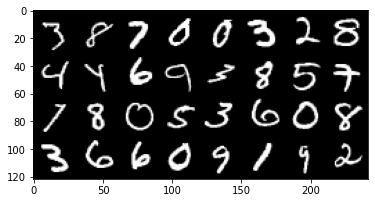

        3         8         7         0


In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%9s' % data['classes'][labels[j]] for j in range(4)))


##A Simple Network##

First we'll build a very basic neural network with a single hidden layer of neurons. This means one fully connected layer of weights connects the input to the hidden neurons and one fully connected layer connects the hidden neurons to the output. We'll use the RELU activation function on the hidden neuron values as our nonlinearity.

These fully connected (or `nn.Linear`) layers expect a 2D input tensor where that is N x I where N is the number of data points in a mini batch and I is the number of inputs. However, our data is formatted in (N x C x H x W) right now so we need to tell PyTorch to rearrange it using `torch.flatten`.

After being `flatten`ed our data goes from (32 x 1 x 28 x 28) to being (32 x 784)

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class SimpleNet(nn.Module):
    def __init__(self, inputs=28*28, hidden=512, outputs=10):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(inputs, hidden)
        self.fc2 = nn.Linear(hidden, outputs)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

###The Training Function ###

Now for training our network. Our `train` function takes as input the `net` to train and the `dataloader` for the training data. It also takes some optional parameters to control training.

For our network we'll be using PyTorch's built in `nn.CrossEntropyLoss`. This will apply a softmax to our network's output, calculate the log-probability assigned to each class, then try to minimize the negative log likelihood of our data (AKA maximize the likelihood)

For our optimizer we are using stochastic gradient descent with learning rate, momentum, and decay parameters.

In [8]:
import torch.optim as optim

def train(net, dataloader, epochs=1, lr=0.01, momentum=0.9, decay=0.0, verbose=1):
  net.to(device)
  losses = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
  for epoch in range(epochs):
    sum_loss = 0.0
    for i, batch in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch[0].to(device), batch[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        losses.append(loss.item())
        sum_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, sum_loss / 100))
            sum_loss = 0.0
  return losses

###Training The Network###

We'll instantiate a new network and train it on our training data.

Our training function prints out some debug information about the epoch, batch number, and current loss values. It also returns a list of all the losses on our mini-batches so we can plot them all once training has finished.

[1,   100] loss: 1.353
[1,   200] loss: 0.505
[1,   300] loss: 0.392
[1,   400] loss: 0.380
[1,   500] loss: 0.363
[1,   600] loss: 0.307
[1,   700] loss: 0.288
[1,   800] loss: 0.294
[1,   900] loss: 0.288
[1,  1000] loss: 0.246
[1,  1100] loss: 0.240
[1,  1200] loss: 0.252
[1,  1300] loss: 0.262
[1,  1400] loss: 0.230
[1,  1500] loss: 0.223
[1,  1600] loss: 0.216
[1,  1700] loss: 0.194
[1,  1800] loss: 0.199


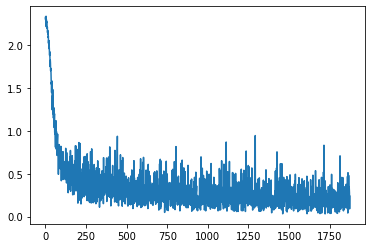

In [9]:
net = SimpleNet()

losses = train(net, data['train'])
plt.plot(losses)

##Testing The Network##

We trained our network! The loss went down! That's good, right? But how good is our network, exactly?

Well, we can try running our network on a few of our test images and see what happens:

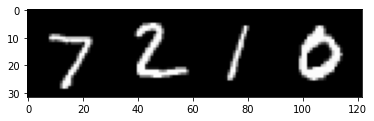

GroundTruth:      7     2     1     0
Predicted:      7     2     1     0


In [10]:
dataiter = iter(data['test'])
images, labels = dataiter.next()
images = images[:4]
labels = labels[:4]

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % data['classes'][labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % data['classes'][predicted[j]]
                              for j in range(4)))

Pretty good so far. But we also want to be able to test the network on all of our data. Here's a function that can do just that, computing the accuracy on a full set of data:

In [11]:
def accuracy(net, dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

Now we can give it a try:

In [12]:
print("Current accuracy: %f" % accuracy(net, data['train']))

Current accuracy: 0.941817


##Experiments##

Now it's time to poke around a little bit with our models. First I just want this utility function to do window smoothing of data for us. As you may have noticed, we are doing *stochastic* gradient descent, so our losses for each mini-batch can vary quite dramatically. If we smooth them out a little bit they will be easier to look at when we plot them.

In [14]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='same')

###Learning Rate###

Let's experiment around with the learning rate of our model. Changing the learning rate should affect how fast our model converges and how accurate it is. We can see the effect when we plot out the loss function over time for models with different learning rates:

0.9564 0.9472 0.8936


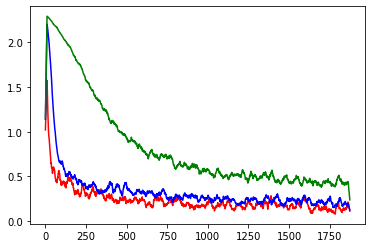

In [14]:
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, verbose=0)
acc_high = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')


net_mid = SimpleNet()
losses_mid = train(net_mid, data['train'], lr=.01, verbose=0)
acc_mid = accuracy(net_mid, data['test'])
plt.plot(smooth(losses_mid,20), 'b-')


net_low = SimpleNet()
losses_low = train(net_low, data['train'], lr=.001, verbose=0)
acc_low = accuracy(net_low, data['test'])
plt.plot(smooth(losses_low,20), 'g-')

print(acc_high, acc_mid, acc_low)

###Momentum###

We are using the default value for momentum of `0.9`. Fix your value for the learning rate and try varying the values for momentum.

####**Question 1: What affect does changing the value for momentum have on your model's convergence and final accuracy?**####

First of all, we tried to figure out the difference between a model with momentum and a model without momentum. According to the "momentum vs no momentum" graph below, the model with momentum converged faster and had better accuracy than the model without momentum. It is reasonable result since momentum allows an optimizer to maintain the velocity and trajectory from previous time steps to affect the present step. 

After that, we searched the best value of momentum by experimenting different values of momentum with binary search (note that the range of momentum can be from 0 to 1). According to the "different values of momentum" graph, we can see that the model converge faster when it has larger momentum, but the acurracy will be the best when momentun is around 0.6.

0.9579 0.9498


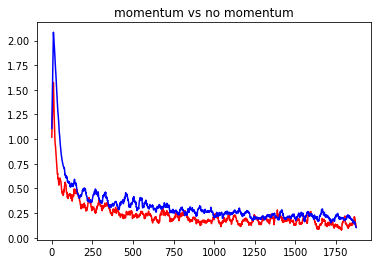

In [15]:
#TODO: Write your code here for experimenting with different values of momentum.
net_momentum = SimpleNet()
losses_momentum = train(net_momentum, data['train'], lr=.1, momentum=0.9, verbose=0)
acc_momentum = accuracy(net_momentum, data['test'])
plt.plot(smooth(losses_high, 20), 'r-')


net_no_momentum = SimpleNet()
losses_no_momentum = train(net_no_momentum, data['train'], lr=.1, momentum=0, verbose=0)
acc_no_momentum = accuracy(net_no_momentum, data['test'])
plt.plot(smooth(losses_no_momentum, 20), 'b-')

plt.title(label="momentum vs no momentum")
print(acc_momentum, acc_no_momentum)

0.9529 0.9663 0.9519


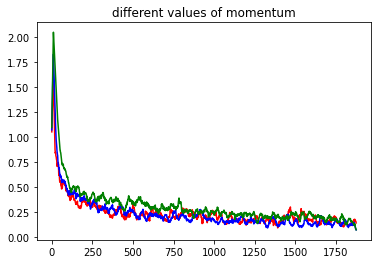

In [16]:
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, momentum=0.9, verbose=0)
acc_high = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')


net_mid = SimpleNet()
losses_mid = train(net_mid, data['train'], lr=.1, momentum=0.6, verbose=0)
acc_mid = accuracy(net_mid, data['test'])
plt.plot(smooth(losses_mid,20), 'b-')


net_low = SimpleNet()
losses_low = train(net_low, data['train'], lr=.1, momentum=0.1, verbose=0)
acc_low = accuracy(net_low, data['test'])
plt.plot(smooth(losses_low,20), 'g-')

plt.title(label="different values of momentum")
print(acc_high, acc_mid, acc_low)

###Weight Decay###

Right now we aren't using any weight decay with our model. However, it can be useful as a method of regularization if we are worried about overfitting.

Take your best performing model parameters from above for learning rate and momentum. Fix these parameters as you answer the following questions:

####**Question 2: Is our current model overfit or underfit to our training data? How can you tell?**####

Right now our current model has high accuracy for both train dataset and test dataset with small differences (around 0.3%).

- Train: 0.9625666666666667 %
- Test: 0.9598 %

It means that our current model is not likely to be overfit. 

We also experimented with 5 epoches, but we still cannot find the trend that the model will likely to overfit.

- Train: 0.9815666666666667 % 
- Test: 0.9761 %

Number of epochs: 1
0.9625666666666667 0.9598
Number of epochs: 5
0.9815666666666667 0.9761


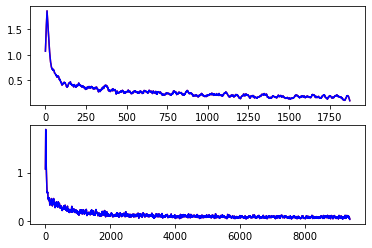

In [18]:
# Difference of accuracies between the train dataset and the test dataset with epoch 1.
net_train = SimpleNet()
losses_train = train(net_train, data['train'], epochs=1, lr=.1, momentum=0.5, decay=0.001, verbose=0)

plt.subplot(2, 1, 1)

acc_train = accuracy(net_train, data['train'])
plt.plot(smooth(losses_train,20), 'r-')

acc_test = accuracy(net_train, data['test'])
plt.plot(smooth(losses_train,20), 'b-')

print("Number of epochs: 1")
print(acc_train, acc_test)

# Difference of accuracies between the train dataset and the test dataset with epoch 5.
net_train = SimpleNet()
losses_train = train(net_train, data['train'], epochs=5, lr=.1, momentum=0.5, decay=0.001, verbose=0)

plt.subplot(2, 1, 2)

acc_train = accuracy(net_train, data['train'])
plt.plot(smooth(losses_train,20), 'r-')

acc_test = accuracy(net_train, data['test'])
plt.plot(smooth(losses_train,20), 'b-')

print("Number of epochs: 5")
print(acc_train, acc_test)

####**Question 3: Try out some different values for weight decay. What effect do they have on model convergence? What about final accuracy? Does this match with what you would have expected? Why or why not?**####

The concept of weight decay is to prevent the weights from growing too large and causing an overfitting. However, according to the previous question, we figures out that our current model might not overfit. In this case, using high weight decay might decrese its accuracy. 

After experimenting with differnt weight decay, we could successfully figure out that as the value of weight decay becomes higer, the accuracy will decrease. It also confirms that our current model does not overfit.

**Accuracies** 
- Decay = 0.01: 0.9182 % 
- Decay = 0.001: 0.9607 %
- Decay = 0.00001: 0.9637 %
- Decay = 0: 0.9644%

0.9182 0.9607 0.9637 0.9644


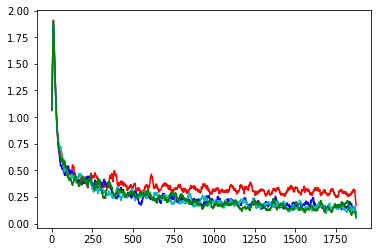

In [20]:
#TODO: Write your code here for experimenting with different weight decay
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, momentum=0.5, decay=0.01, verbose=0)
acc_high = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')


net_mid1 = SimpleNet()
losses_mid1 = train(net_mid1, data['train'], lr=.1, momentum=0.5, decay=0.001, verbose=0)
acc_mid1 = accuracy(net_mid1, data['test'])
plt.plot(smooth(losses_mid1,20), 'b-')


net_mid2 = SimpleNet()
losses_mid2 = train(net_mid2, data['train'], lr=.1, momentum=0.5, decay=0.0001, verbose=0)
acc_mid2 = accuracy(net_mid2, data['test'])
plt.plot(smooth(losses_mid2,20), 'c-')


net_low = SimpleNet()
losses_low = train(net_low, data['train'], lr=.1, momentum=0.5, decay=0, verbose=0)
acc_low = accuracy(net_low, data['test'])
plt.plot(smooth(losses_low,20), 'g-')

print(acc_high, acc_mid1, acc_mid2, acc_low)

###A Bigger Model###

Before we used a very simple model but now it's time to try adding some complexity. Create a network that takes as input the 28x28 image, 10 outputs, and any number of layers as long as it has fewer than 2,000,000 connections. Our simple network before had 784\*512 + 512\*10 = 406,528 connections.

Use only fully connected (`nn.Linear`) layers (we'll get to other layer types soon). However, play around with different [activation functions](https://pytorch.org/docs/stable/nn.functional.html#non-linear-activation-functions), [losses](https://pytorch.org/docs/stable/nn.html#loss-functions), and hyperparameter settings. You can also try different training regimes. For example, you could try lowering the learning rate during training by calling our training method twice like this:

    train(net, data['train'], epochs=5, lr=.1)
    train(net, data['train'], epochs=3, lr=.01)
    train(net, data['train'], epochs=2, lr=.001)

Maybe it works better? Why did I choose those particular numbers? Who knows! It's deep learning, no one really knows what will work you have to just try things and see.

Experiment with different network architectures and settings to get the most accurate model.

####**Question 4: Describe your final model architecture. How did you come up with the number of layers and number of neurons at each layer?**####

Our final model is a neural network with 2-layer and 800 hidden units. First of all, we set the number of layer to two since MNIST dataset has only 10 patterns. The article, "the number of hidden layers", wrriten by Jeff Heaton, said, "Two hidden layer can represent an arbitrary decision boundary to arbitrary accuracy with rational activation functions and can approximate any smooth mapping to any accuracy.", so we think it is reasonable choice. 

After that, we searched how many hidden units can result in the best accuraccy. If we chose higher number, the accuracy for the test data will increase, but once we start changing hyperparameters, we figured out that 800 (around the number of input node) could be the best result.

####**Question 5: What hyperparameters did you experiment with? What values were good for them? Do you think your model was over or under fitting the data?**####

We experimented with number of epochs and the decay since we have already figured out the best learning rate and momentum. When we increse the number of epochs to more than 15, our model will converge at around 98.5%. 
We have also increased the decay to check if our model is overfitting or not. Since the accuracy for bothe train dataset and testdataset will descrese when we add the decay (0.001), we can confirm that it is not overfitting. 

In [67]:
#TODO: Write your new model and experiments here

# Our final model
class ExperiNet1(nn.Module):
    #TODO: Change all this
    def __init__(self):
        super(ExperiNet1, self).__init__()
        self.fc1 = nn.Linear(28*28, 800)
        self.fc2 = nn.Linear(800, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

# Other model for comparison
class ExperiNet2(nn.Module):
    #TODO: Change all this
    def __init__(self):
        super(ExperiNet2, self).__init__()
        self.fc1 = nn.Linear(28*28, 2500)
        self.fc2 = nn.Linear(2500, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

0.9999666666666667 0.985


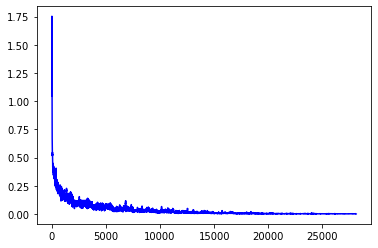

In [75]:
# our final model with 15 epochs, 0.1 learning rate, 0.6 momentum, and no decay.
experi_net = ExperiNet1()
experi_losses = train(experi_net, data['train'], epochs=15, lr=.1, momentum=0.6, verbose=0)
experi_acc_train = accuracy(experi_net, data['train'])
experi_acc_test = accuracy(experi_net, data['test'])
plt.plot(smooth(experi_losses, 20), 'b-')

print(experi_acc_train, experi_acc_test)

0.98175 0.9766


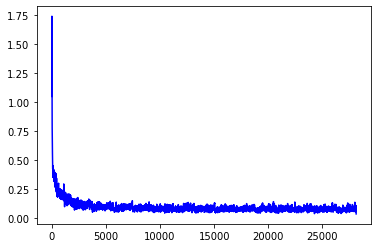

In [78]:
# our final model with 15 epochs, 0.1 learning rate, 0.6 momentum, and 0.001 decay.
experi_net = ExperiNet1()
experi_losses = train(experi_net, data['train'], epochs=15, lr=.1, momentum=0.6, decay=0.001, verbose=0)
experi_acc_train = accuracy(experi_net, data['train'])
experi_acc_test = accuracy(experi_net, data['test'])
plt.plot(smooth(experi_losses, 20), 'b-')

print(experi_acc_train, experi_acc_test)

1.0 0.985


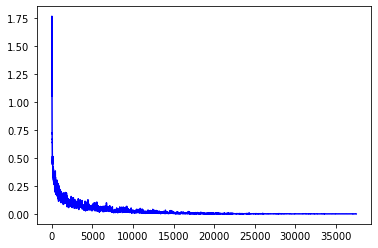

In [77]:
# our final model with 20 epochs, 0.1 learning rate, 0.6 momentum, and no decay.
experi_net = ExperiNet1()
experi_losses = train(experi_net, data['train'], epochs=20, lr=.1, momentum=0.6, verbose=0)
experi_acc_train = accuracy(experi_net, data['train'])
experi_acc_test = accuracy(experi_net, data['test'])
plt.plot(smooth(experi_losses, 20), 'b-')

print(experi_acc_train, experi_acc_test)

0.9939833333333333 0.9785


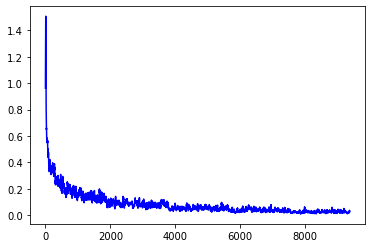

In [69]:
# With 2500 hidden nodes, the accuracy will not increase as well as 800 hidden nodes 
# when increasing the number of epochs. 
experi_net = ExperiNet2()
experi_losses = train(experi_net, data['train'], epochs=5, lr=.1, momentum=0.6, verbose=0)
experi_acc_train = accuracy(experi_net, data['train'])
experi_acc_test = accuracy(experi_net, data['test'])
plt.plot(smooth(experi_losses, 20), 'b-')

print(experi_acc_train, experi_acc_test)

##Download and submit!##

Download your iPythorn notebook from Colab to your `hw0` directory. Then follow the instructions to collate and submit your homework.